# Basic Setup, Downloading data, etc.

## Imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from cycler import cycler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

## Configure kaggle

In [2]:
!pip install kaggle --upgrade

### hide my kaggle key :D

In [3]:
!echo "{\"username\":\"tombohorig\",\"key\":\"81f7fcd3a57da42eb3f3c20e0417fdfe\"}" > kaggle.json

### finish configuring

In [4]:
!sudo mkdir -p ~/.kaggle
!sudo cp /content/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle --version

Kaggle API 1.5.4


## Download data

In [8]:
!kaggle competitions download -c ieee-fraud-detection

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


### Read in data

In [9]:
np.random.seed(314159)
train_txn = pd.read_csv('/content/train_transaction.csv.zip', compression='zip')
test_txn = pd.read_csv('/content/test_transaction.csv.zip', compression='zip')
train_id = pd.read_csv('/content/train_identity.csv.zip', compression='zip')

### Split training into train/validation set

In [9]:
#_RESPONSE = 'isFraud'
#y_df = train_txn[_RESPONSE]
#x_df = train_txn
#del x_df[_RESPONSE]

#train_txn, valid_txn = train_test_split(train_txn, test_size=0.25, stratify=train_txn['isFraud'])

# Very basic EDA

In [10]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

prop_cycle=(cycler('color', color_pal))

In [11]:
train_txn.shape

(590540, 394)

In [12]:
#valid_txn.shape

Below we will see the first 10 column names of the train_txn dataframe

In [13]:
list(train_txn.columns)[:10]

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5']

Below we see that the only column missing from test_txn is the isFraud column. This is normal as the test data set never contaings the target feature columns

In [ ]:
set(train_txn.columns) - set(test_txn.columns)

{'isFraud'}

In [ ]:
test_txn.shape

(506691, 393)

In [ ]:
train_txn.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,0.045507,0.052002,0.251761,0.283140,0.264208,1.000007,139.748713,408.682375,230.413180,10.995986,118.195658,4.202175,39.173910,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584,6.220289,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,0.289573,0.318310,0.481889,0.623608,0.528238,0.002603,2348.849634,4391.992977,3021.924247,116.254277,352.983093,102.374938,172.128339,95.902970,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171,56.022561,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.

Below we see that the percentage of fradulent payments in this data frame is 3.4 percent. This means that if a model guesses not fraud every single time then it will be 96.6 percent accurate.

In [ ]:
isFraud = train_txn[train_txn['isFraud']==1]['isFraud']
isNotFraud = train_txn[train_txn['isFraud']==0]['isFraud']
print('Num fraud: {}\nNon non-fraud: {}\nPercent fraud: {}'.format(isFraud.count(), isNotFraud.count(), isFraud.count()/(isNotFraud.count()+isFraud.count())))

Num fraud: 20663
Non non-fraud: 569877
Percent fraud: 0.03499000914417313


Below is a histogram of the percentage of fraudulent payments. Although I believe the above analysis is clearer, this shows that the amount of fraudulent payments is very small in proportion. This also means that the thing we are looking for (fraudulent payments) is imbalanced and we may have to use techniques like SMOTE to deal with the class imbalance.

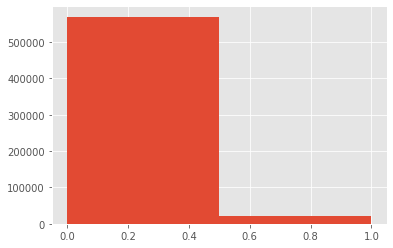

In [ ]:
train_txn['isFraud'].hist(bins=2)

Below we see the type of Product CD. Here we can see that Products labelled W are very prominent in the data set while C occurs almost double the remaining features, and R and H are about equal, and S has the least occurences. It will be interesting to see later in the EDA if any of thse features are more prominent in fraudelent payments.

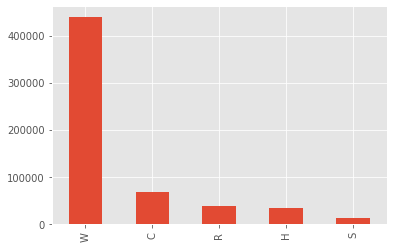

In [ ]:
train_txn['ProductCD'].value_counts().plot(kind='bar')

The goal of the list_pcnt function is to list the percentage of fraudulent payments per unqiue value in a given column. So the function takes in a feature/column and returns to the user all the elements in that column and the percentage of fraudlent payments. It will be interesting to see if any features are above 3.4 percent as that is the amount of fraudlent payments. Since the goal is to find frauduelent payment we are seeking more positives and not negatives so it is more important to find frauds (which will have high percentages) as opposed to not frauds which will be lower percentages. One interesting thing to note in this function is that there is a threshold paramater. This paramater is to filter out elements in a column that are not frequent as they are not determinant of when a user will experience fraud as it is not general.

In [ ]:
def list_pcnt(feature, threshold=1, data=train_txn):
  pe = data.groupby([feature, 'isFraud'])['TransactionID'].count()
  values = data[feature].unique()
  values = [x for x in values if x==x]
  for v in values:
    det = pe[v]
    if(len(det) > 1):
      nf = det[0]
      f = det[1]
      total = nf+f
      if total > threshold:
        print("Percent", v, "is fraud:", round(100*f/(total), 2), "% of", total)
    else:
      if det[0] > threshold:
        print("Percent", v, "is fraud: 0")

The column card 4 denotes the type of card a user used in their transactio. Based on the below data we can see that the Discover cards are over twice more likely to be fraud than the average percentage of fraudulent payments which was 3.4. The other types of card types or around or below the average of 3.4 percent so they are not as interesting to detect fraud.

In [ ]:
list_pcnt('card4')

Percent discover is fraud: 7.73 % of 6651
Percent mastercard is fraud: 3.43 % of 189217
Percent visa is fraud: 3.48 % of 384767
Percent american express is fraud: 2.87 % of 8328


This text block is devoted to the next 2 code blocks as it is interesting to analyze them together. It is unclear what P and R play as a role in this data set. It seems to be that R is the recipient email address how is getting frauded, and P is the one sending fraudlent emails buti it is unsure. What is interesting however, is that the email addresses in both feautures display very different percentages of fraudlent transactions. The only email addresses associated with "P" that are above average is outlook and gmail. Outlok is interesting b/c it is almost three times higher than the average we found earlier and could be a great indicator while gmail is a bit closer to average. However, pointing out that gmail is slightly above average in the "P" column but over triple more likely than the average in the "R" column is very interesting. It could point out that either gmail is less secure, of that so many more users use gmail that they are more likely to be targeted for fraud resulting in a higher percentage while other email users are less targeted. It would be very interesting to see also how many were targetted but sucessfully neutralized as it would give much more insights to the frequency and safety of each email endpoint.

In [ ]:
list_pcnt('P_emaildomain', 1000)

Percent gmail.com is fraud: 4.35 % of 228355
Percent outlook.com is fraud: 9.46 % of 5096
Percent yahoo.com is fraud: 2.28 % of 100934
Percent anonymous.com is fraud: 2.32 % of 36998
Percent hotmail.com is fraud: 5.3 % of 45250
Percent verizon.net is fraud: 0.81 % of 2705
Percent aol.com is fraud: 2.18 % of 28289
Percent me.com is fraud: 1.77 % of 1522
Percent comcast.net is fraud: 3.12 % of 7888
Percent optonline.net is fraud: 1.68 % of 1011
Percent cox.net is fraud: 2.08 % of 1393
Percent icloud.com is fraud: 3.14 % of 6267
Percent live.com is fraud: 2.76 % of 3041
Percent att.net is fraud: 0.74 % of 4033
Percent ymail.com is fraud: 2.09 % of 2396
Percent sbcglobal.net is fraud: 0.4 % of 2970
Percent bellsouth.net is fraud: 2.78 % of 1909
Percent msn.com is fraud: 2.2 % of 4092
Percent yahoo.com.mx is fraud: 1.04 % of 1543


In [ ]:
list_pcnt('R_emaildomain', 1000)

Percent gmail.com is fraud: 11.92 % of 57147
Percent hotmail.com is fraud: 7.78 % of 27509
Percent outlook.com is fraud: 16.51 % of 2507
Percent anonymous.com is fraud: 2.91 % of 20529
Percent comcast.net is fraud: 1.16 % of 1812
Percent icloud.com is fraud: 12.88 % of 1398
Percent yahoo.com is fraud: 5.15 % of 11842
Percent aol.com is fraud: 3.49 % of 3701
Percent yahoo.com.mx is fraud: 1.06 % of 1508


We have already analyzed the graph directly below this text block above, but pairing this graph and the one below is very interesting! The difference between these graphs is that one shows total count of ProductCD broken up by unique values, while the second (red) graph shows the percentage of fraud broken up by each unique value in Product CD. It is very interesting to note that although W is the most frequesnt element in Product CD it has the lowest amount of fraud. However, as our goal is to determine fraud, I believe the most interesgint reature to oeserve is C as over 11 percent of times this feature is mentioned in the data set ic corellated to fraud. That is over triple the avearage and can be a great indicator to fraudulent transactions.

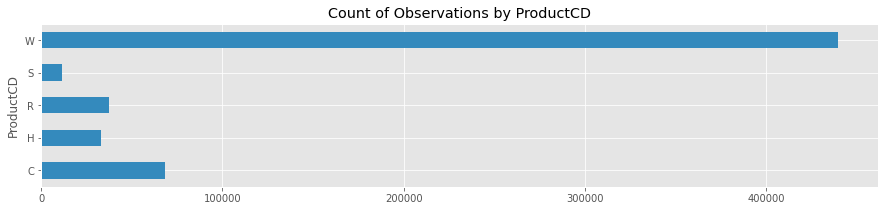

In [ ]:
train_txn.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
        figsize=(15, 3),
        title='Count of Observations by ProductCD',
        color=color_pal[1])
plt.show()

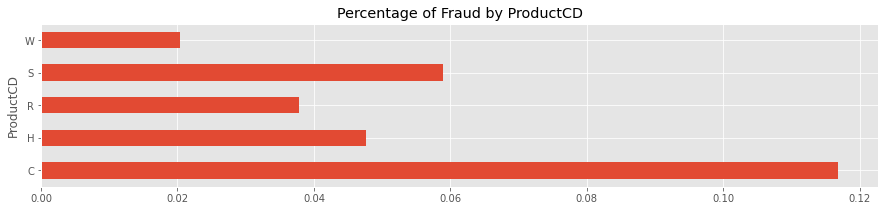

In [ ]:
train_txn.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

The graph below shares a similar teme to the two above, however, the graph on the left instead of showing percentage shows total aount. It is interesting to note that althogh W appears over 4 more times than C in non-fraudulent transactions they have nearly the same amount of fraudulent transactions associated to one another. This could show that like aboce that C is a major indicator for fraud. However, C does not appear frequently enough to make a good model on its own, but it will be good in assiting the model to detect fraud.

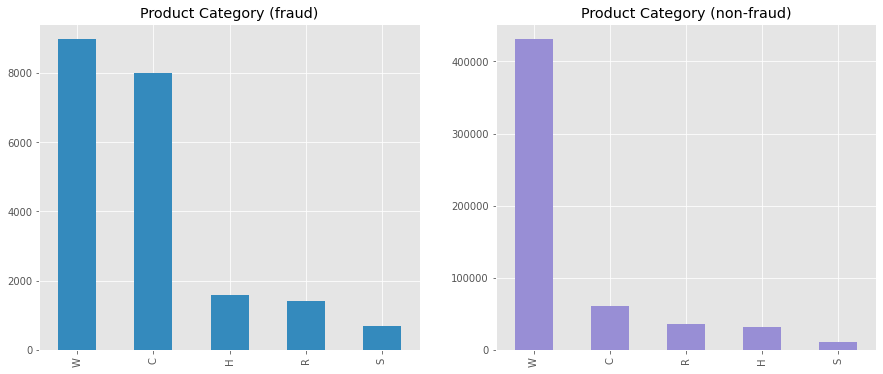

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))
train_txn.loc[train_txn['isFraud'] == 1] \
    ['ProductCD'].value_counts() \
    .plot(kind='bar',
          title='Product Category (fraud)',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train_txn.loc[train_txn['isFraud'] == 0] \
    ['ProductCD'].value_counts() \
    .plot(kind='bar',
          title='Product Category (non-fraud)',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
plt.show()

In [ ]:
#drop categorical features with high cardinality
new_df = train_txn.drop(columns=['P_emaildomain', 'R_emaildomain'])

#one-hot remaining categorical features
new_df = pd.get_dummies(new_df, columns=['ProductCD'], prefix=['ProductCD'])
new_df = pd.get_dummies(new_df, columns=['card4'], prefix=['card4'])
new_df = pd.get_dummies(new_df, columns=['card6'], prefix=['card6'])



#drop columns that have >=25% missing values
size = train_txn.shape[0]
#new_df = new_df.dropna(axis=1, thresh=(.25 * size))

#drop rows that still have missing values (won't drop more than 25% of dataset, guaranteed above)
#new_df = new_df.dropna(axis=0)

#binary encode M1-9
encode = lambda truth: 1 if truth=="T" else 0
for i in range(1,10):
  label = "M" + str(i)
  new_df[label] = new_df[label].apply(encode)

In [ ]:
new_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584,6.220289,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882,0.116028,0.055922,0.063838,0.019690,0.744522,0.014102,0.011263,0.320414,0.651551,0.000025,0.252288,0.744976,0.000051
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,95.902970,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171,56.022561,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722,0.320258,0.229771,0.244465,0.138934,0.436130,0.117913,0.105526,0.466636,0.476479,0.005040,0.434326,0.435875,0.007127
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [ ]:
def plot_corr(df,size=10):
    """Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
    """
    import matplotlib.pyplot as plt

    inter_cols = [
      'TransactionID',
      'isFraud',
      'TransactionDT',
      'TransactionAmt',
      'ProductCD_W',
      'ProductCD_C',
      'ProductCD_H',
      'ProductCD_R',
      'ProductCD_S',
      ]
    corr = df.corrwith(new_df[inter_cols])
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(inter_cols.columns)), inter_cols.columns)

    plt.savefig("corr_plot.png", bbox_inches = 'tight')

#plot_corr(new_df, new_df.shape[1])

#from IPython.display import Image
#Image('corr_plot.png')

In [ ]:
lim_corr = new_df.corrwith(new_df['isFraud'])

The below table shows the corellation to fraud excluding any column that begins with a V. We saw in class that the corellations with V were very high, but it is also interesting to note other features as the ones with V are very vague and hard to make an intuition on. The main three features that have a strong corellation to fraud are Protuct CD C element which makes sense since we saw that before. However, it is interesting to note that before we saw that it only had around 11 percent corellation and here there is a bit more than 16 percent corellation. The other features are card 3 and card6_crebit. It is interesting that the credit is so high as opposed to debit and charge cards and it is ery interesting to include that in the model.

In [ ]:
lim_corr.filter(regex='[^V\d+]', axis=0).sort_values(ascending=False).head(50)

isFraud                   1.000000
ProductCD_C               0.161442
card3                     0.154151
card6_credit              0.100508
C2                        0.037229
C8                        0.032139
C12                       0.031905
C1                        0.030570
C4                        0.030382
C10                       0.028396
C7                        0.028160
C11                       0.027484
card4_discover            0.024564
dist1                     0.021522
C6                        0.020909
ProductCD_S               0.018515
ProductCD_H               0.016784
TransactionID             0.014166
TransactionDT             0.013103
TransactionAmt            0.011320
C14                       0.007921
M5                        0.006953
addr1                     0.005596
ProductCD_R               0.004030
card2                     0.003388
card6_charge card        -0.000960
card6_debit or credit    -0.001357
card4_visa               -0.001741
card4_mastercard    

In [ ]:
lim_corr.filter(regex='[^V\d+]', axis=0).sort_values().head(50)

D8                       -0.142636
ProductCD_W              -0.135549
D7                       -0.127199
card6_debit              -0.099779
M1                       -0.089400
M2                       -0.089079
M3                       -0.084136
D2                       -0.083583
D15                      -0.077519
D10                      -0.072002
M9                       -0.068434
M6                       -0.068134
D4                       -0.067216
D1                       -0.067193
D5                       -0.064638
D13                      -0.059430
D6                       -0.057236
D3                       -0.046271
D11                      -0.045094
D9                       -0.044253
M8                       -0.043045
card5                    -0.033580
C9                       -0.031703
C5                       -0.030754
addr2                    -0.030387
D12                      -0.028864
dist2                    -0.019054
M7                       -0.017003
card1               

Here we can see that all te training data takes place before the test data. It is interesting to note this b/c it means that time can have an effect on the model. However, it seems to not have an effect when we look at the graph side by side. One dominant feature that is remarkable is that the transaction dates seem to be more left skewed on training data and right skewed on the test data. I do not believe this will help a model better detect fraud or not, but it is interesting to note.

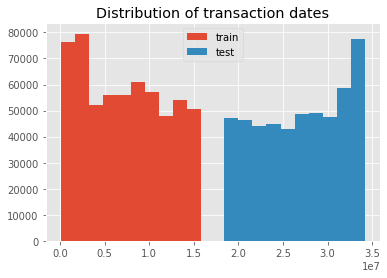

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train_txn['TransactionDT'], label='train');
plt.hist(test_txn['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transaction dates');
plt.show()

In [ ]:
frauds = train_txn.loc[train_txn['isFraud'] == 1]
frauds


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,credit,251.0,87.0,NaN,NaN,aol.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,45.041664,0.041666,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,credit,NaN,NaN,NaN,NaN,outlook.com,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590361,3577361,1,15807368,1224.000,W,3278,453.0,150.0,visa,226.0,debit,191.0,87.0,26.0,NaN,yahoo.com,NaN,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,6.0,3.0,63.0,63.0,31.0,382.0,31.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590364,3577364,1,15807516,69.964,C,5812,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,24.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,0.0,0.0,112.0,NaN,20.0,113.0,20.0,113.0,20.0,NaN,NaN,...,0.0,0.0,1.0,2.0,1.0,1.0,0.0,48.0774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0774,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590368,3577368,1,15807677,100.000,H,6758,399.0,150.0,american express,146.0,credit,299.0,87.0,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590372,3577372,1,15807758,117.000,W,14037,111.0,150.0,visa,226.0,credit,272.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0

In [ ]:
notfraud = train_txn.loc[train_txn['isFraud'] == 0].sample(n=20663)
even = pd.concat([frauds,notfraud], ignore_index=True)
even = even.loc[:,~even.columns.str.startswith('V')]
even

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,credit,251.0,87.0,NaN,NaN,aol.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,374.0,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN
1,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
2,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
4,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,credit,NaN,NaN,NaN,NaN,outlook.com,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41321,3195152,0,4809947,59.000,W,6363,517.0,150.0,mastercard,224.0,debit,327.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,11.0,11.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,M0,F,NaN,NaN,NaN,NaN
41322,3115287,0,2560133,310.950,W,11207,361.0,150.0,visa,226.0,debit,126.0,87.0,11.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,NaN,NaN,F,F,F,T
41323,3399697,0,10429819,70.000,W,15678,111.0,150.0,mastercard,224.0,debit,143.0,87.0,58.0,NaN,aol.com,NaN,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,1.0,345.0,345.0,22.0,345.0,22.0,NaN,NaN,NaN,NaN,345.0,345.0,NaN,NaN,NaN,345.0,T,T,T,NaN,NaN,F,F,F,F
41324,3259531,0,6623227,100.000,R,17188,321.0,150.0,visa,226.0,debit,299.0,87.0,NaN,NaN,yahoo.com,yahoo.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
trimmed = train_txn.loc[:,~train_txn.columns.str.startswith('V')]

I will perform the analysis of both corellation plots here. The difference between the two plots is that one of them remove the features with v. However, it seems that the first correlation plot does not display the v features as well. So it seems as if they are both duplicative plots. We can see that each column that begins with the same s heavily corellated with one another. This is to be expected as they all represent similar chacteristics. Simething I find to be quire interesting is that card 3 seems to corellate negatively or near zero with many of the other features. Regaarding just the corellation it seems that the only true corellations are when thins are compared within categories that begin with the same letter like C1,C2,...,C14.

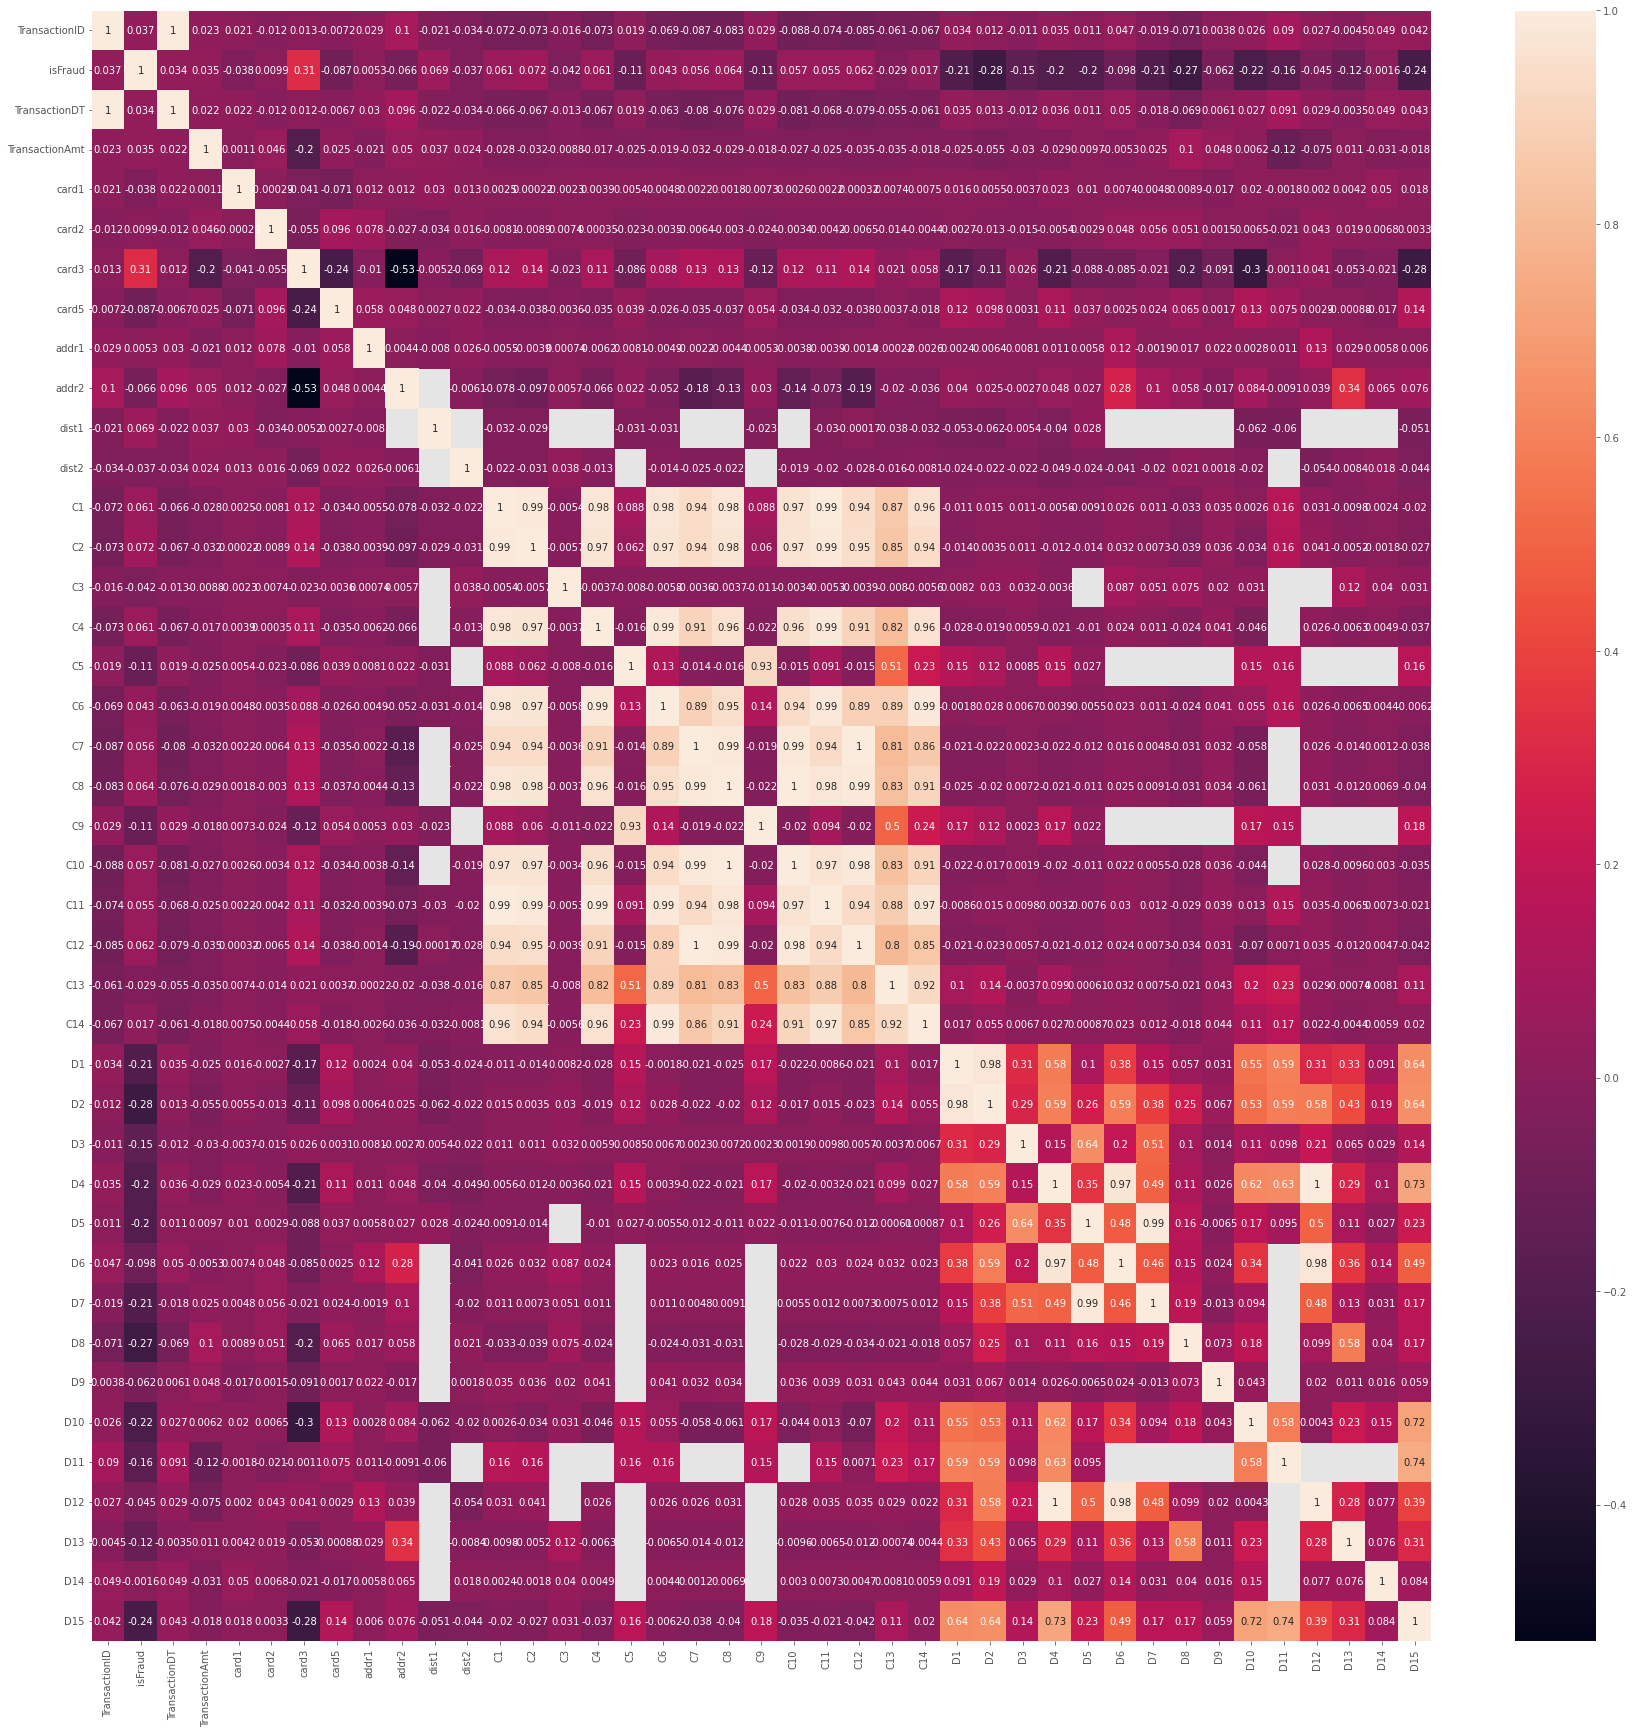

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 30]

corrMatrix = even.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

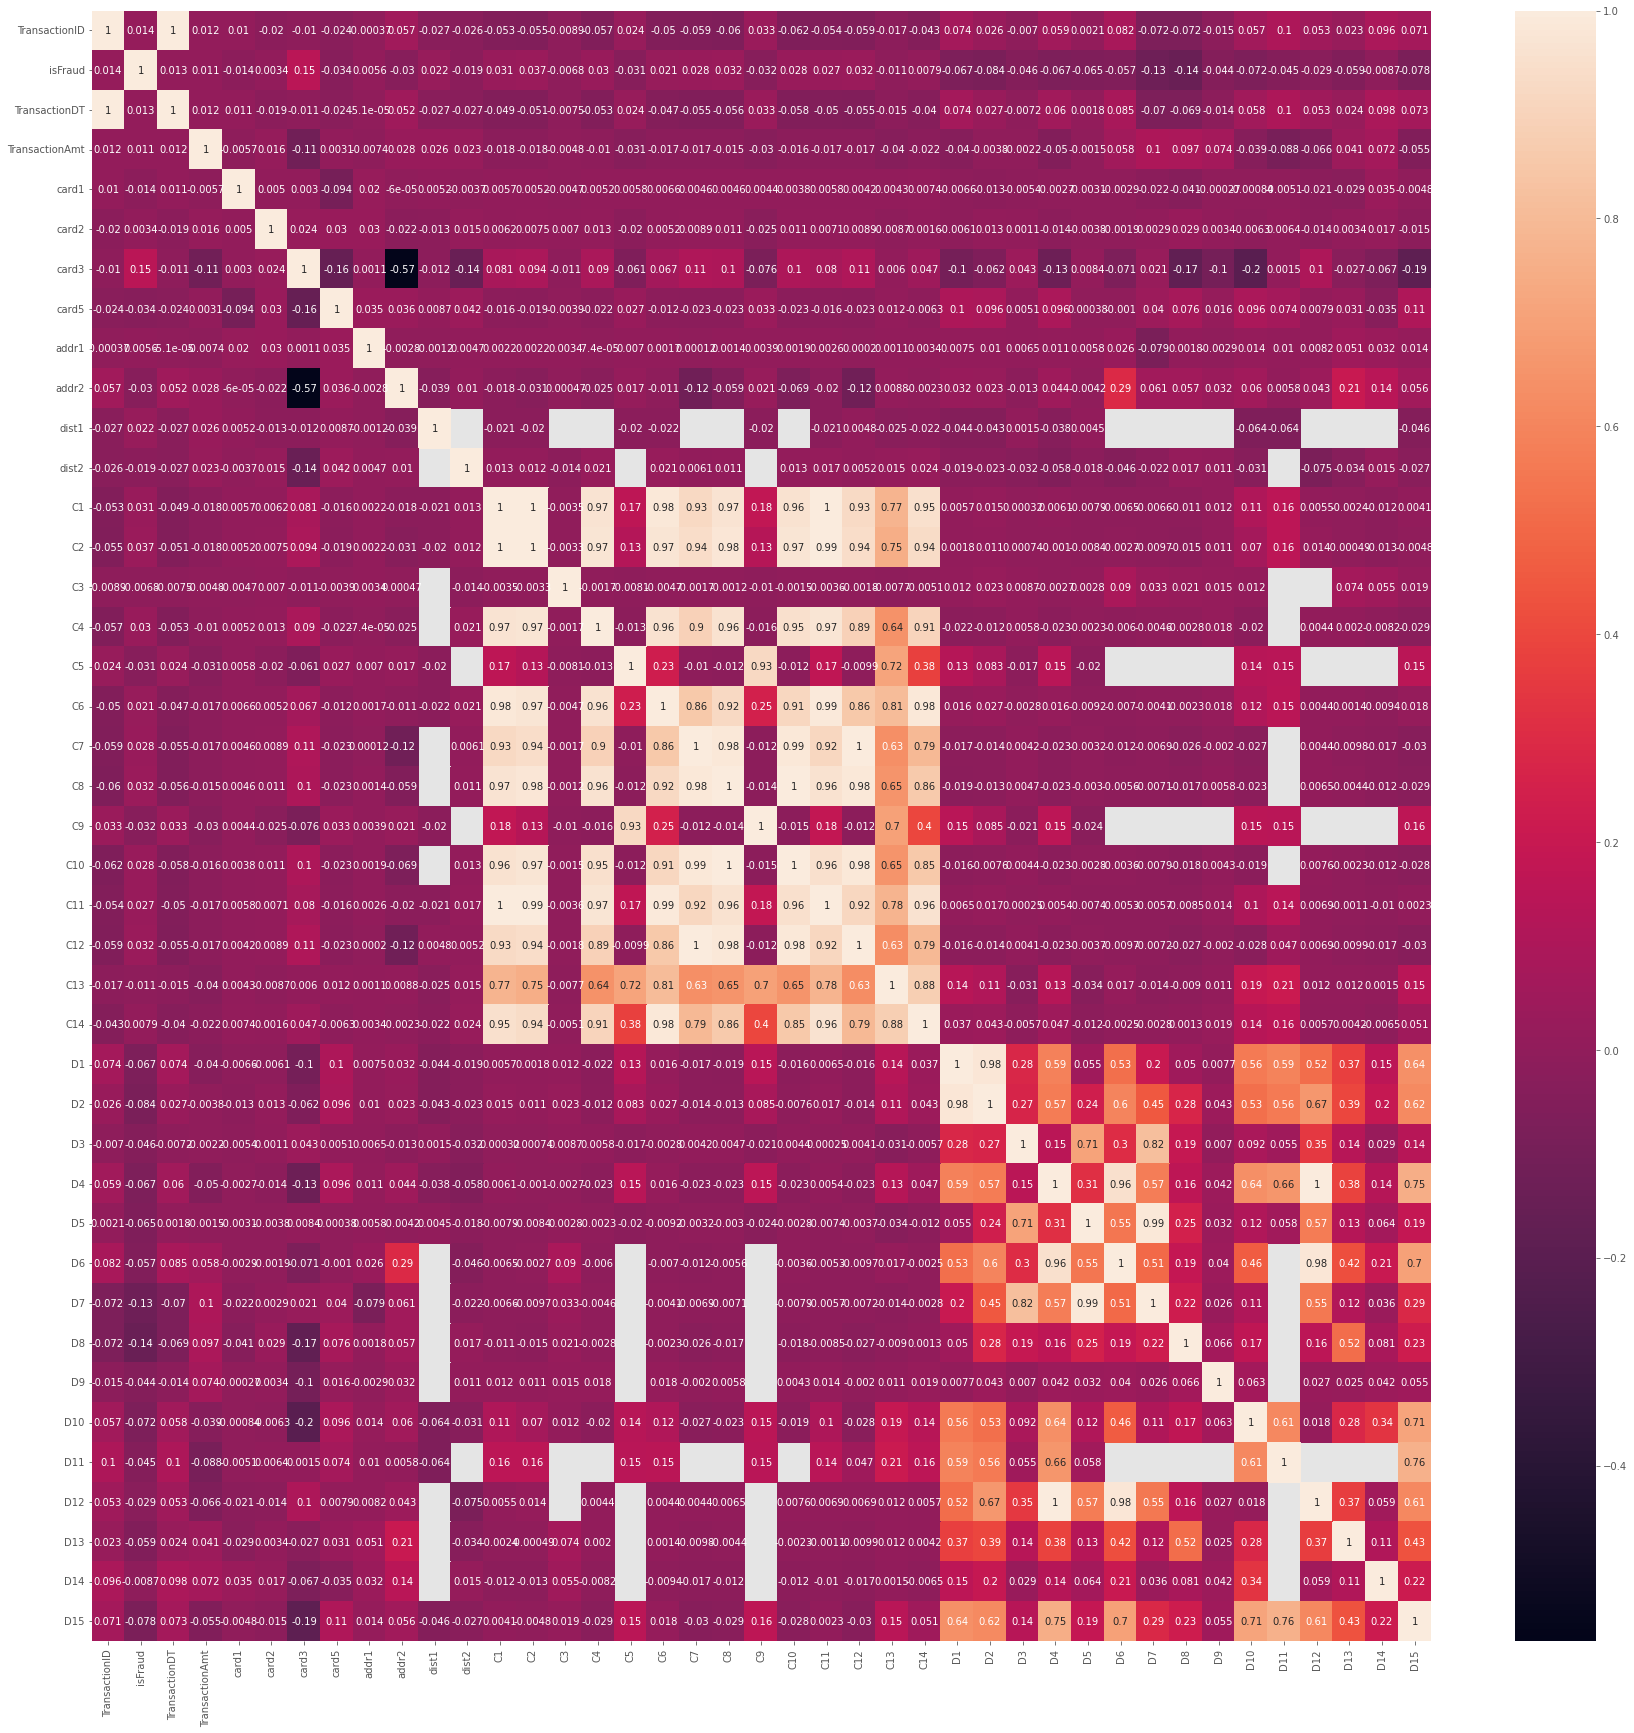

In [ ]:
corrMatrixTrim = trimmed.corr()
sn.heatmap(corrMatrixTrim, annot=True)
plt.show()

There seems to be the same graph two times below. Please see the below text block to see the analysis on the graph as it is more zoomed in and easier to analyze.

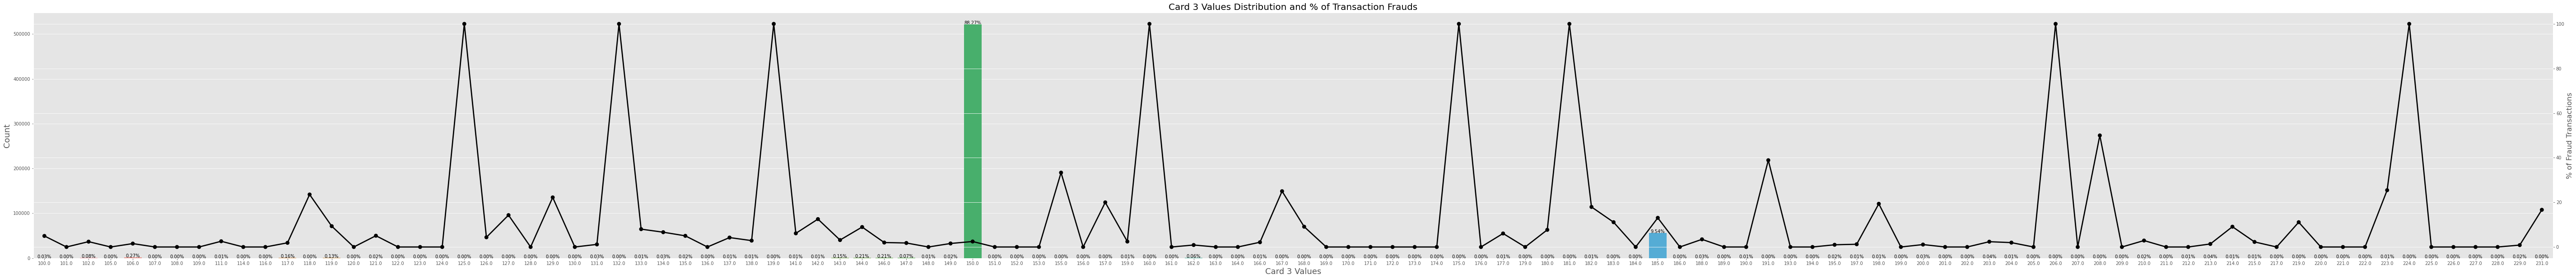

In [ ]:
# from some kaggle eda to plot the 

total = len(trimmed)

tmp = pd.crosstab(trimmed['card3'], trimmed['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(100,10))

g2 = sn.countplot(x='card3', data=trimmed, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sn.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 


In [ ]:
trimmed[["card3","isFraud"]][trimmed["card3"]==125]
# trimmed[["card3","isFraud"]][trimmed["card3"]==125]

,card3,isFraud
193170,125.0,1


The purpose of the graph below is to show the fraud and at which amounts it mostly takes blace. It seems like the black dos represent how much fraud took place on the card 3 value/ It is interecting to nte that most card 3 values take place at 150 and 185, and the other points in the graph seem to be much less regular. So it seems like the only two crucial points of this graph are at 150 and 185 as they show a better and more accurate representation of how much fraud takes place when card 3 has those values.

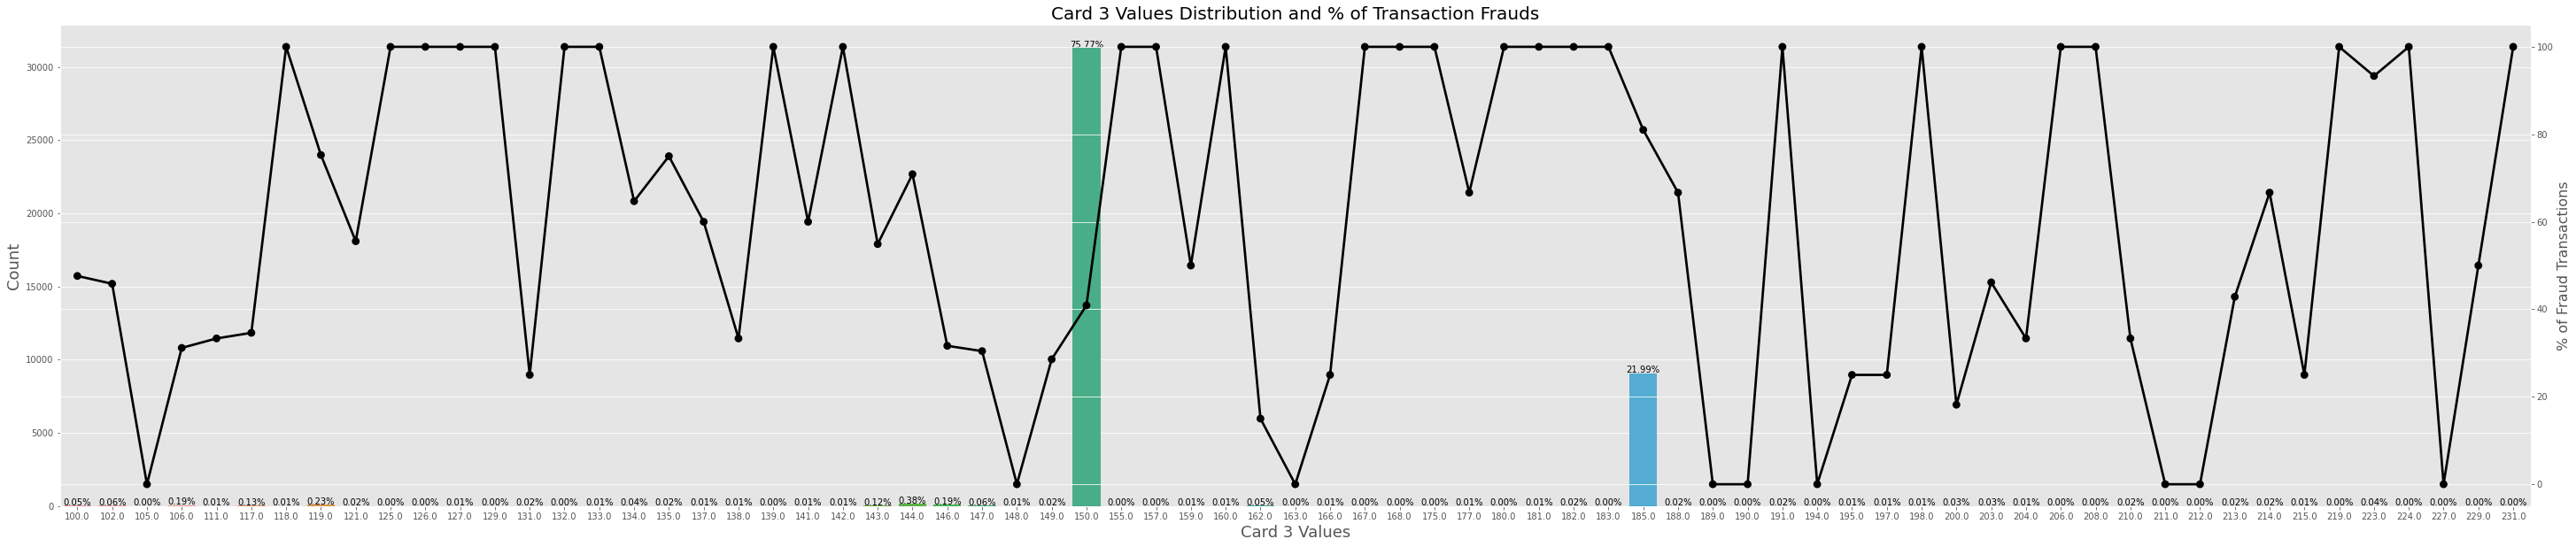

In [ ]:
# from some kaggle eda to plot the 

total = len(even)

tmp = pd.crosstab(even['card3'], even['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(50,10))

g2 = sn.countplot(x='card3', data=even, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sn.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 


In [ ]:
even[["isFraud","card3"]]

,isFraud,card3
0,1,150.0
1,1,185.0
2,1,185.0
3,1,185.0
4,1,185.0
...,...,...
41321,0,150.0
41322,0,150.0
41323,0,150.0
41324,0,150.0


I have noticed that there is not much EDA on the id data set so I will preform some of that EDA below

In [10]:
# Merge both data frames so you have isFraud on train_id data set:
merged_df = pd.merge(train_txn, train_id, how='outer')

# Create a merged dataframe seperating fraud vs. not fraud to better visualize data side by side:
fraud_df = merged_df.loc[merged_df['isFraud'] == 1]
non_fraud_df = merged_df.loc[merged_df['isFraud'] == 0]

In [11]:
# function to graph features and fraud vs. non fraud side by side:
def fraud_vs_nonfraud(feature):
  fig, ((ax1, ax2)) = plt.subplots(2, figsize=(10, 10))
  fraud_df.groupby(feature)[feature].count().plot(kind='barh', ax=ax1, title=f'{feature} fraud')
  non_fraud_df.groupby(feature)[feature].count().plot(kind='barh', ax=ax2, title=f'{feature} non-fraud')
  plt.show()

In the graph below we do not see any major difference in fraud type, as they seem to have the same proportion. In this single graph card type does not seem to have a large impact on the fraudlent transactions.

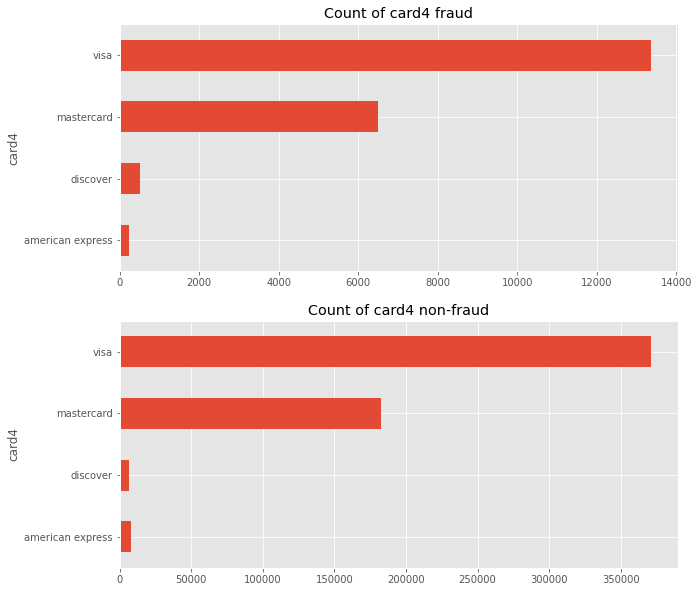

In [36]:
fraud_vs_nonfraud(feature='card4')

The graph below is interesting to see, b/c there seems to be be many more debit card non-fraudlent transactions, but when just comparing fraudlent transactions the ratio between credit and debit seems to be almost perfectly even. This shows that credit card transactions are much more likely to be fraud.

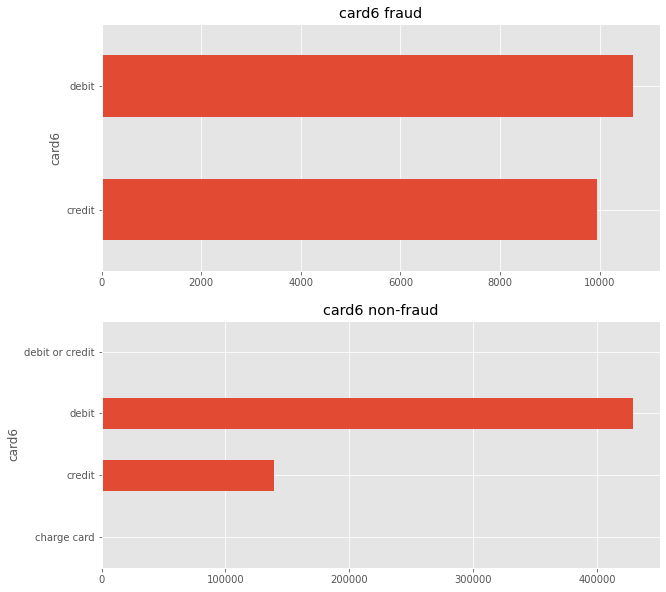

In [43]:
fraud_vs_nonfraud(feature='card6')

Nothing very interesting in graph below as it has similar proportions

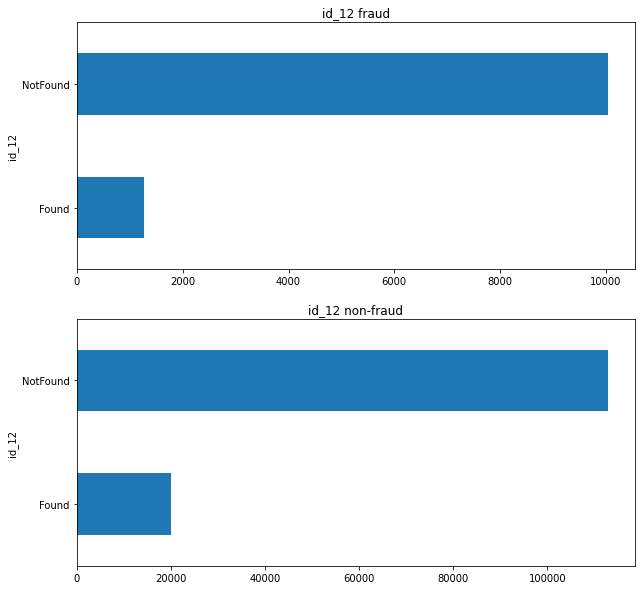

In [12]:
fraud_vs_nonfraud(feature='id_12')

Something interesting to note heere is that the attribute Found has a much higher proportion of fraud even though it has a similar amount of non fraudulent transactions. It has around 11 percent fraudlent transactions. That means that this attribute must be quite important for the model.

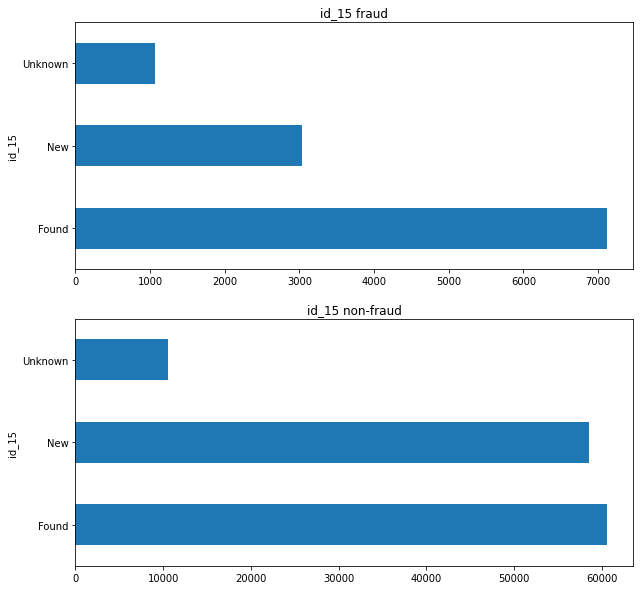

In [13]:
fraud_vs_nonfraud(feature='id_15')

Aother interesting feature to note is the Found attribute here as it has nearly 12 percent fraudlent transactions as well. That is nearly quadruple the average amount of fraud. It is quite interesting to look at these as they were not mention in class last week.

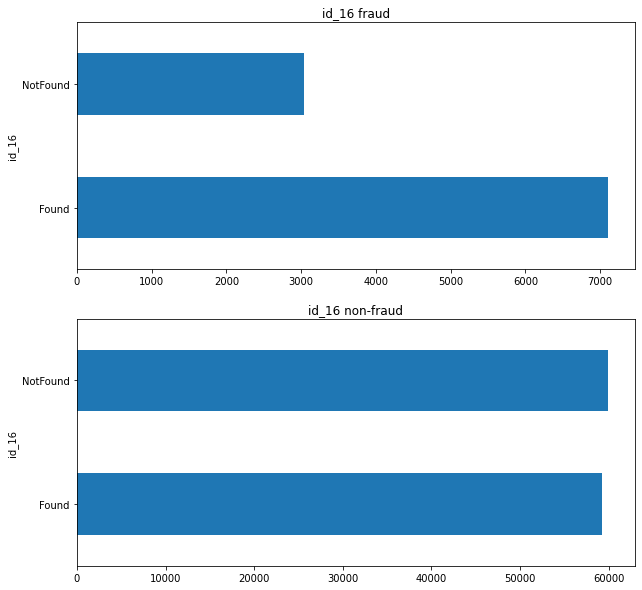

In [14]:
fraud_vs_nonfraud(feature='id_16') 

In the diagram we actually see that F has less non fraudelnt transactions but then spikes up when it comes to fraud. It has around 14 percent frauduelnt transactions which is over quadruple the averagae amount showing another crucial column that should be included in the model.

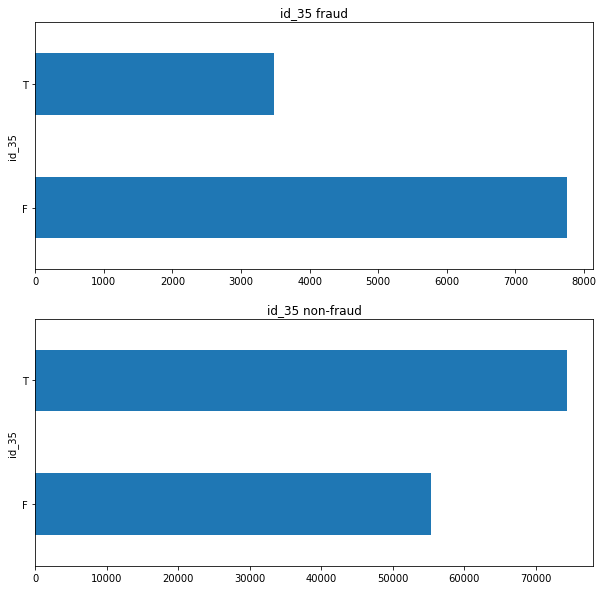

In [15]:
fraud_vs_nonfraud(feature='id_35') 